In [21]:
import numpy as np
import pandas as pd
import math
from scipy.stats import t
import matplotlib.pyplot as plt
from collections import deque

In [22]:
# -------------------------------------------------------------------------
# This is an ANSI C library for multi-stream random number generation.  
#  * The use of this library is recommended as a replacement for the ANSI C 
#  * rand() and srand() functions, particularly in simulation applications 
#  * where the statistical 'goodness' of the random number generator is 
#  * important.  The library supplies 256 streams of random numbers; use 
#  * SelectStream(s) to switch between streams indexed s = 0,1,...,255.
#  *
#  * The streams must be initialized.  The recommended way to do this is by
#  * using the function PlantSeeds(x) with the value of x used to initialize 
#  * the default stream and all other streams initialized automatically with
#  * values dependent on the value of x.  The following convention is used 
#  * to initialize the default stream:
#  *    if x > 0 then x is the state
#  *    if x < 0 then the state is obtained from the system clock
#  *    if x = 0 then the state is to be supplied interactively.
#  *
#  * The generator used in this library is a so-called 'Lehmer random number
#  * generator' which returns a pseudo-random number uniformly distributed
#  * 0.0 and 1.0.  The period is (m - 1) where m = 2,147,483,647 and the
#  * smallest and largest possible values are (1 / m) and 1 - (1 / m)
#  * respectively.  For more details see:
#  * 
#  *       "Random Number Generators: Good Ones Are Hard To Find"
#  *                   Steve Park and Keith Miller
#  *              Communications of the ACM, October 1988
#  *
#  * Name            : rngs.c  (Random Number Generation - Multiple Streams)
#  * Authors         : Steve Park & Dave Geyer
#  * Language        : ANSI C
#  * Latest Revision : 09-22-98
#  * Translated by     : Philip Steele 
#  * Language          : Python 3.3
#  * Latest Revision   : 3/26/14
#  *
#  * ------------------------------------------------------------------------- 

from time import time

#global consts
MODULUS = 2147483647 #/* DON'T CHANGE THIS VALUE                  */
MULTIPLIER = 48271      #/* DON'T CHANGE THIS VALUE                  */
CHECK = 399268537  #/* DON'T CHANGE THIS VALUE                  */
STREAMS = 256        #/* # of streams, DON'T CHANGE THIS VALUE    */
A256 = 22925      #/* jump multiplier, DON'T CHANGE THIS VALUE */
DEFAULT = 123456789  #/* initial seed, use 0 < DEFAULT < MODULUS  */

#statics
stream = 0
initialized = 0
seed = [DEFAULT]
for i in range(1,STREAMS):
  seed.append(DEFAULT)


def random(): 
  #/* ---------------------------------------------------------------------
  #* Random is a Lehmer generator that returns a pseudo-random real number
  #* uniformly distributed between 0.0 and 1.0.  The period is (m - 1)
  #* where m = 2,147,483,647 amd the smallest and largest possible values
  #* are (1 / m) and 1 - (1 / m) respectively.
  #* ---------------------------------------------------------------------
  #*/
  global seed

  Q = int(MODULUS / MULTIPLIER)
  R = int(MODULUS % MULTIPLIER)

  t = int(MULTIPLIER * (seed[stream] % Q) - R * int(seed[stream] / Q))
  if (t > 0):
    seed[stream] = int(t)
  else:
    seed[stream] = int(t + MODULUS)

  return float(seed[stream] / MODULUS)

def plantSeeds(x): 
  # /* --------------------------------------------------------------------
  #  * Use this function to set the state of all the random number generator
  #  * streams by "planting" a sequence of states (seeds), one per stream,
  #  * with all states dictated by the state of the default stream.
  #  * The sequence of planted states is separated one from the next by
  #  * 8,367,782 calls to Random().
  #  * ---------------------------------------------------------------------
  #  */
  global initialized
  global stream
  global seed

  Q = int(MODULUS / A256)
  R = int(MODULUS % A256)

  initialized = 1
  s = stream                             #/* remember the current stream */
  selectStream(0)                        #/* change to stream 0          */
  putSeed(x)                             #/* set seed[0]                 */
  stream = s                             #/* reset the current stream    */
  for j in range(1,STREAMS):
    x = int(A256 * (seed[j - 1] % Q) - R * int((seed[j - 1] / Q)))
    if (x > 0):
      seed[j] = x
    else:
      seed[j] = x + MODULUS
  

def putSeed(x):
  # /* -------------------------------------------------------------------
  #  * Use this (optional) procedure to initialize or reset the state of
  #  * the random number generator according to the following conventions:
  #  *    if x > 0 then x is the initial seed (unless too large)
  #  *    if x < 0 then the initial seed is obtained from the system clock
  #  *    if x = 0 then the initial seed is to be supplied interactively
  #  * --------------------------------------------------------------------
  #  */
  global seed 

  ok = False

  if (x > 0):
    x = x % MODULUS  
                            # correct if x is too large  
  if (x < 0): 
    x = time()
    x = x % MODULUS
  
  if (x == 0):
    while (ok == False): 
      line = input("\nEnter a positive integer seed (9 digits or less) >> ")
      x = int(line)
      ok = (0 < x) and (x < MODULUS)
      if (ok == False):
        print("\nInput out of range ... try again\n")
    
    
  seed[stream] = int(x)


def getSeed():
  # /* --------------------------------------------------------------------
  #  * Use this (optional) procedure to get the current state of the random
  #  * number generator.
  #  * --------------------------------------------------------------------
  #  */
  global seed
  return seed[stream]


def selectStream(index):
  #/* ------------------------------------------------------------------
  #* Use this function to set the current random number generator
  #* stream -- that stream from which the next random number will come.
  #* ------------------------------------------------------------------
  #*/
  global stream 

  stream = index % STREAMS
  if (initialized == 0) and (stream != 0):   #/* protect against        */
    plantSeeds(DEFAULT)                     #/* un-initialized streams */
    


  
def testRandom():
  # /* -------------------------------------------------------------------
  #  * Use this (optional) procedure to test for a correct implementation.
  #  * -------------------------------------------------------------------
  #  */

  ok = False

  selectStream(0)                  #/* select the default stream */
  putSeed(1)                       #/* and set the state to 1    */
  for i in range(0,10000):
    u = random()
  x = getSeed()                    #/* get the new state value   */
  ok = (x == CHECK)                #/* and check for correctness */
  
  selectStream(1)                  #/* select stream 1                 */
  plantSeeds(1)                    #/* set the state of all streams    */
  x = getSeed()                    #/* get the state of stream 1       */
  ok = (ok==True) and (x == A256)           #/* x should be the jump multiplier */
  if (ok==True):
    print("\n The implementation of Rngs.py is correct")
  else:
    print("\n ERROR - the implementation of Rngs.py is not correct")

  

In [23]:
#-------------------------------------------------------------------------- 
 #This is an ANSI C library for generating random variates from six discrete 
 #distributions
 #
 #     Generator         Range (x)     Mean         Variance
 #
 #     Bernoulli(p)      x = 0,1       p            p*(1-p)
 #     Binomial(n, p)    x = 0,...,n   n*p          n*p*(1-p)
 #     Equilikely(a, b)  x = a,...,b   (a+b)/2      ((b-a+1)*(b-a+1)-1)/12
 #     Geometric(p)      x = 0,...     p/(1-p)      p/((1-p)*(1-p))
 #     Pascal(n, p)      x = 0,...     n*p/(1-p)    n*p/((1-p)*(1-p))
 #     Poisson(m)        x = 0,...     m            m
 #
 #and seven continuous distributions
 #
 #     Uniform(a, b)     a < x < b     (a + b)/2    (b - a)*(b - a)/12 
 #     Exponential(m)    x > 0         m            m*m
 #     Erlang(n, b)      x > 0         n*b          n*b*b
 #     Normal(m, s)      all x         m            s*s
 #     Lognormal(a, b)   x > 0            see below
 #     Chisquare(n)      x > 0         n            2*n 
 #     Student(n)        all x         0  (n > 1)   n/(n - 2)   (n > 2)
 #
 #For the a Lognormal(a, b) random variable, the mean and variance are
 #
 #                       mean = exp(a + 0.5*b*b)
 #                   variance = (exp(b*b) - 1) #exp(2*a + b*b)
 #
 #Name              : rvgs.c  (Random Variate GeneratorS)
 #Author            : Steve Park & Dave Geyer
 #Language          : ANSI C
 #Latest Revision   : 10-28-98
 #Translated by     : Philip Steele 
 #Language          : Python 3.3
 #Latest Revision   : 3/26/14
 # 
 #--------------------------------------------------------------------------


from math import log,sqrt,exp
# -------------------------------------------------------------------------
# This is an ANSI C library for multi-stream random number generation.  
#  * The use of this library is recommended as a replacement for the ANSI C 
#  * rand() and srand() functions, particularly in simulation applications 
#  * where the statistical 'goodness' of the random number generator is 
#  * important.  The library supplies 256 streams of random numbers; use 
#  * SelectStream(s) to switch between streams indexed s = 0,1,...,255.
#  *
#  * The streams must be initialized.  The recommended way to do this is by
#  * using the function PlantSeeds(x) with the value of x used to initialize 
#  * the default stream and all other streams initialized automatically with
#  * values dependent on the value of x.  The following convention is used 
#  * to initialize the default stream:
#  *    if x > 0 then x is the state
#  *    if x < 0 then the state is obtained from the system clock
#  *    if x = 0 then the state is to be supplied interactively.
#  *
#  * The generator used in this library is a so-called 'Lehmer random number
#  * generator' which returns a pseudo-random number uniformly distributed
#  * 0.0 and 1.0.  The period is (m - 1) where m = 2,147,483,647 and the
#  * smallest and largest possible values are (1 / m) and 1 - (1 / m)
#  * respectively.  For more details see:
#  * 
#  *       "Random Number Generators: Good Ones Are Hard To Find"
#  *                   Steve Park and Keith Miller
#  *              Communications of the ACM, October 1988
#  *
#  * Name            : rngs.c  (Random Number Generation - Multiple Streams)
#  * Authors         : Steve Park & Dave Geyer
#  * Language        : ANSI C
#  * Latest Revision : 09-22-98
#  * Translated by     : Philip Steele 
#  * Language          : Python 3.3
#  * Latest Revision   : 3/26/14
#  *
#  * ------------------------------------------------------------------------- 

from time import time

#global consts
MODULUS = 2147483647 #/* DON'T CHANGE THIS VALUE                  */
MULTIPLIER = 48271      #/* DON'T CHANGE THIS VALUE                  */
CHECK = 399268537  #/* DON'T CHANGE THIS VALUE                  */
STREAMS = 256        #/* # of streams, DON'T CHANGE THIS VALUE    */
A256 = 22925      #/* jump multiplier, DON'T CHANGE THIS VALUE */
DEFAULT = 123456789  #/* initial seed, use 0 < DEFAULT < MODULUS  */

#statics
stream = 0
initialized = 0
seed = [DEFAULT]
for i in range(1,STREAMS):
  seed.append(DEFAULT)


def random(): 
  #/* ---------------------------------------------------------------------
  #* Random is a Lehmer generator that returns a pseudo-random real number
  #* uniformly distributed between 0.0 and 1.0.  The period is (m - 1)
  #* where m = 2,147,483,647 amd the smallest and largest possible values
  #* are (1 / m) and 1 - (1 / m) respectively.
  #* ---------------------------------------------------------------------
  #*/
  global seed

  Q = int(MODULUS / MULTIPLIER)
  R = int(MODULUS % MULTIPLIER)

  t = int(MULTIPLIER * (seed[stream] % Q) - R * int(seed[stream] / Q))
  if (t > 0):
    seed[stream] = int(t)
  else:
    seed[stream] = int(t + MODULUS)

  return float(seed[stream] / MODULUS)

def plantSeeds(x): 
  # /* --------------------------------------------------------------------
  #  * Use this function to set the state of all the random number generator
  #  * streams by "planting" a sequence of states (seeds), one per stream,
  #  * with all states dictated by the state of the default stream.
  #  * The sequence of planted states is separated one from the next by
  #  * 8,367,782 calls to Random().
  #  * ---------------------------------------------------------------------
  #  */
  global initialized
  global stream
  global seed

  Q = int(MODULUS / A256)
  R = int(MODULUS % A256)

  initialized = 1
  s = stream                             #/* remember the current stream */
  selectStream(0)                        #/* change to stream 0          */
  putSeed(x)                             #/* set seed[0]                 */
  stream = s                             #/* reset the current stream    */
  for j in range(1,STREAMS):
    x = int(A256 * (seed[j - 1] % Q) - R * int((seed[j - 1] / Q)))
    if (x > 0):
      seed[j] = x
    else:
      seed[j] = x + MODULUS
  

def putSeed(x):
  # /* -------------------------------------------------------------------
  #  * Use this (optional) procedure to initialize or reset the state of
  #  * the random number generator according to the following conventions:
  #  *    if x > 0 then x is the initial seed (unless too large)
  #  *    if x < 0 then the initial seed is obtained from the system clock
  #  *    if x = 0 then the initial seed is to be supplied interactively
  #  * --------------------------------------------------------------------
  #  */
  global seed 

  ok = False

  if (x > 0):
    x = x % MODULUS  
                            # correct if x is too large  
  if (x < 0): 
    x = time()
    x = x % MODULUS
  
  if (x == 0):
    while (ok == False): 
      line = input("\nEnter a positive integer seed (9 digits or less) >> ")
      x = int(line)
      ok = (0 < x) and (x < MODULUS)
      if (ok == False):
        print("\nInput out of range ... try again\n")
    
    
  seed[stream] = int(x)


def getSeed():
  # /* --------------------------------------------------------------------
  #  * Use this (optional) procedure to get the current state of the random
  #  * number generator.
  #  * --------------------------------------------------------------------
  #  */
  global seed
  return seed[stream]


def selectStream(index):
  #/* ------------------------------------------------------------------
  #* Use this function to set the current random number generator
  #* stream -- that stream from which the next random number will come.
  #* ------------------------------------------------------------------
  #*/
  global stream 

  stream = index % STREAMS
  if (initialized == 0) and (stream != 0):   #/* protect against        */
    plantSeeds(DEFAULT)                     #/* un-initialized streams */
    


  
def testRandom():
  # /* -------------------------------------------------------------------
  #  * Use this (optional) procedure to test for a correct implementation.
  #  * -------------------------------------------------------------------
  #  */

  ok = False

  selectStream(0)                  #/* select the default stream */
  putSeed(1)                       #/* and set the state to 1    */
  for i in range(0,10000):
    u = random()
  x = getSeed()                    #/* get the new state value   */
  ok = (x == CHECK)                #/* and check for correctness */
  
  selectStream(1)                  #/* select stream 1                 */
  plantSeeds(1)                    #/* set the state of all streams    */
  x = getSeed()                    #/* get the state of stream 1       */
  ok = (ok==True) and (x == A256)           #/* x should be the jump multiplier */
  if (ok==True):
    print("\n The implementation of Rngs.py is correct")
  else:
    print("\n ERROR - the implementation of Rngs.py is not correct")

  

def Bernoulli(p):
  #========================================================
  #Returns 1 with probability p or 0 with probability 1 - p. 
  #NOTE: use 0.0 < p < 1.0                                   
  #========================================================
  
  if (random() < 1 - p):
    return(0)
  else:
    return(1)


def Binomial(n,p):
  #================================================================ 
  #Returns a binomial distributed integer between 0 and n inclusive. 
  #NOTE: use n > 0 and 0.0 < p < 1.0
  #================================================================
  
  x = 0

  for i in range(0,n):
    x += Bernoulli(p)
  return (x)

def Equilikely(a,b):
  #===================================================================
  #Returns an equilikely distributed integer between a and b inclusive. 
  #NOTE: use a < b
  #===================================================================
  return (a + int((b - a + 1) * random()))

def Geometric(p):
  #====================================================
  #Returns a geometric distributed non-negative integer.
  #NOTE: use 0.0 < p < 1.0
  #====================================================
  #

  return (int(log(1.0 - random()) / log(p)))


def Pascal(n,p):
  #================================================= 
  #Returns a Pascal distributed non-negative integer. 
  #NOTE: use n > 0 and 0.0 < p < 1.0
  #=================================================
  #
   
  x = 0

  for i in range(0,n):
    x += Geometric(p)
  return (x)

def Poisson(m):
  #================================================== 
  #Returns a Poisson distributed non-negative integer. 
  #NOTE: use m > 0
  #==================================================
  # 
  t = 0.0
  x = 0

  while (t < m): 
    t += Exponential(1.0)
    x += 1
  
  return (x - 1)

def Uniform(a,b):
  #=========================================================== 
  #Returns a uniformly distributed real number between a and b. 
  #NOTE: use a < b
  #===========================================================
  #
  return (a + (b - a) * random())

def Exponential(m):
  #=========================================================
  #Returns an exponentially distributed positive real number. 
  #NOTE: use m > 0.0
  #=========================================================
  #
  return (-m * log(1.0 - random()))

def Hyperexponential(p, l1, l2):
  # ====================================================================
  # Returns a hyperexponential distributed positive real number.
  # NOTE: 0.0 < p < 1.0, l1 > 0.0, l2 > 0.0
  # It returns an exponential with rate l1 with probability p,
  # otherwise with rate l2 with probability (1 - p)
  # ====================================================================
  #
  if (random() < p):
    return Exponential(1.0 / l1)
  else:
    return Exponential(1.0 / l2)

def Erlang(n,b):
  #================================================== 
  #Returns an Erlang distributed positive real number.
  #NOTE: use n > 0 and b > 0.0
  #==================================================
  #
  x = 0.0

  for i in range(0,n): 
    x += Exponential(b)
  return (x)

def Normal(m,s):
  #========================================================================
  #Returns a normal (Gaussian) distributed real number.
  #NOTE: use s > 0.0
  #
  #Uses a very accurate approximation of the normal idf due to Odeh & Evans, 
  #J. Applied Statistics, 1974, vol 23, pp 96-97.
  #========================================================================
  #
  p0 = 0.322232431088     
  q0 = 0.099348462606
  p1 = 1.0                
  q1 = 0.588581570495
  p2 = 0.342242088547     
  q2 = 0.531103462366
  p3 = 0.204231210245e-1  
  q3 = 0.103537752850
  p4 = 0.453642210148e-4  
  q4 = 0.385607006340e-2

  u = random()
  if (u < 0.5):
    t = sqrt(-2.0 * log(u))
  else:
    t = sqrt(-2.0 * log(1.0 - u))

  p   = p0 + t * (p1 + t * (p2 + t * (p3 + t * p4)))
  q   = q0 + t * (q1 + t * (q2 + t * (q3 + t * q4)))

  if (u < 0.5):
    z = (p / q) - t
  else:
    z = t - (p / q)

  return (m + s * z)

def Lognormal(a,b):
  # ==================================================== 
  #Returns a lognormal distributed positive real number. 
  #NOTE: use b > 0.0
  #====================================================
  #
  return (exp(a + b * Normal(0.0, 1.0)))

def Chisquare(n):
  #=====================================================
  #Returns a chi-square distributed positive real number. 
  #NOTE: use n > 0
  #=====================================================
  #
  x = 0.0

  for i in range(0,n):
    z  = Normal(0.0, 1.0)
    x += z * z

  return (x)


def Student(n):
  #=========================================== 
  #Returns a student-t distributed real number.
  #NOTE: use n > 0
  #===========================================
  #
  return (Normal(0.0, 1.0) / sqrt(Chisquare(n) / n))

def testFunctions():
  #tests to ensure that all variates match what was produced by C version of program (with the same order and parameters)

  #bernoulli 
  bern = []
  for i in range(0,10):
    bern.append(Bernoulli(.65))

  if (bern == [0,0,1,0,1,0,1,1,1,1]):
    print("Bernoulli test passed")
  else:
    print("FIX BERNOULLI!")

  #binomial
  bino = Binomial(50,.19)
  if (bino == 7):
    print("Binomial test passed")
  else:
    print("FIX BINOMIAL")
    print(bino)

  #equilikely 
  equi = Equilikely(32,108)
  if (equi ==77):
    print("Equilikely test passed")
  else:
    print("FIX EQUILIKELY")

  #geo test
  geo = []
  for i in range(0,10):
    geo.append(Geometric(.93))

  if (geo == [0,8,4,21,7,3,17,5,14,1]):
    print("Geo test passed")
  else:
    print("Fix geo!")
    print(geo)

  #pascal test
  pas = Pascal(87,.93)
  if (pas == 1407):
    print("Pascal test passed!")
  else:
    print("FIX PASCAL")

  #poisson test
  pois = Poisson(13.3)
  if (pois == 15):
    print("Poisson test passed!")
  else:
    print("FIX POISSON!")

  #uniform test
  uni = Uniform(32,108)
  if (round(uni,6) == 78.976127):
    print("Uniform test passed!")
  else:
    print("FIX UNIFORM. Produced: ", uni)
    print("Expected: 78.976127")

  #exp test
  exp = Exponential(4.7)
  if (round(exp,6) == 4.796404):
    print("Exponential test passed!")
  else:
    print("FIX EXP. Produced: ", exp)
    print("expected: 4.796404")

  #erlang test
  erl = Erlang(41,.08)
  if (round(erl,6) == 2.824873):
    print("Erland test passed!")
  else:
    print("FIX ERLANG Produced: ", erl)
    print("Expected: 2.824873")

  #normal test
  norm = Normal(8.9,4)
  if (round(norm,6) == 8.374243):
    print("Normal test passed!")
  else:
    print("FIX NORMAL Produced: ",norm)
    print("Expected: 8.374243")

  #lognormal test
  lnorm = Lognormal(1.31,1.6)
  if (round(lnorm,6) == 5.533064):
    print("Lognormal test passed!")
  else:
    print("FIX LOGNORMAL Produced: ", lnorm)
    print("Expected: 5.533064")

  #chisq test
  chisq = Chisquare(39)
  if (round(chisq,6) == 33.634524):
    print("Chisquare test passed!")
  else:
    print("FIX CHI-SQUARE - Produced: ", chisq)
    print("Expected: 33.634524")

  #t test
  stu = Student(61)
  if (round(stu,6) == -1.429058):
    print("Student test passed!")
  else:
    print("FIX STUDENT - Produced: ", stu)
    print("Expected: -1.429058")

In [24]:
# STREAM IDs
STREAM_ARR = 0
STREAM_A_1   = 1
STREAM_A_2   = 2
STREAM_A_3   = 3
STREAM_B   = 4
STREAM_P   = 5

In [25]:
import math, heapq
import pandas as pd

def simulate_ps_ABAPA_fast(
    lmb, mu_A1, mu_B, mu_A2, mu_P, mu_A3,
    threshold_time, eps=1e-12
):
   

    def stage_server_name(pos): 
        return ["A","B","A","P","A"][pos-1]

    def a_visit_index_after(pos): 
        return [1,1,2,2,3][pos-1]
    
  

    def draw_demand_for(pos):
        if pos == 1:
            selectStream(STREAM_A_1)   
            return Exponential(1/mu_A1)
        if pos == 2: 
            selectStream(STREAM_B)   
            return Exponential(1/mu_B)
        if pos == 3: 
            selectStream(STREAM_A_2)   
            return Exponential(1/mu_A2)
        if pos == 4: 
            selectStream(STREAM_P)   
            return Exponential(1/mu_P)
        if pos==5: 
            selectStream(STREAM_A_3)   
            return Exponential(1/mu_A3)

    # Stato server con PS: S = service tag, heap di finish tag F
    class PSServer:
        __slots__ = ("name","c","S","n","heap","N_time_accum")
        def __init__(self,name,c=1.0):
            self.name=name; self.c=c
            self.S=0.0; self.n=0
            self.heap=[]   # (F, jid, segobj)
            self.N_time_accum=0.0

    servers = {k:PSServer(k,1.0) for k in ("A","B","P")}

    # Stato globale
    selectStream(STREAM_ARR) 
    t=0.0
    mean_inter=1.0/float(lmb)
    next_arrival = t + Exponential(mean_inter)
    job_id=0
    jobs_rows=[]
    jobs_info = {}  # jid -> dict

    # Helper: avanzamento tempo delta aggiornando S e N_time_accum
    def advance(delta):
        nonlocal t
        if delta <= 0: 
            return
        # accumulo N(t)*dt
        for srv in servers.values():
            srv.N_time_accum += srv.n * delta
        # avanço dei service tag
        for srv in servers.values():
            if srv.n>0:
                srv.S += (srv.c / srv.n) * delta
        t += delta

    # Ammetti segmento (visita) su un server PS
    def admit_segment(jid,pos,server_name,arrival_t):
        srv = servers[server_name]
        d = draw_demand_for(pos)

        # numero di job attivi all'ammissione (incluso questo)
        n_at_admit = srv.n + 1

        seg = {
            "job_id": jid, 
            "pos": pos, 
            "server": server_name,
            "a_visit": a_visit_index_after(pos),
            "arrival_stage": arrival_t,
            "IN": arrival_t,                    # in PS puro ammissione = arrivo
            "S_admit": srv.S,                   # tag all'ammissione
            "Demand": d,
            "N_at_Admit": n_at_admit
        }
        F = seg["S_admit"] + d
        heapq.heappush(srv.heap, (F, jid, seg))
        srv.n += 1
        return seg

    # Main loop
    INF = math.inf
    def arrivals_open(): 
        return (next_arrival is not None and next_arrival <= threshold_time)

    def work_left():
        if arrivals_open(): 
            return True
        return any(srv.n>0 for srv in servers.values())

    while work_left():
        # Prossimo completamento su ciascun server in tempo reale
        next_comp_time = INF
        comp_srv = None

        for srv in servers.values():
            if srv.n==0 or not srv.heap: 
                continue
            F_min, _, _ = srv.heap[0]
            if F_min <= srv.S + 1e-15:
                dt_srv = 0.0
            else:
                dS = F_min - srv.S
                dt_srv = dS * (srv.n / srv.c)
            tc = t + dt_srv
            if tc < next_comp_time:
                next_comp_time = tc
                comp_srv = srv

        ta = next_arrival if arrivals_open() else INF
        t_next = min(ta, next_comp_time)
        if math.isinf(t_next):
            break

        # Avanza il tempo fino al prossimo evento
        advance(t_next - t)

        # Evento
        if abs(t_next - ta) <= 1e-12:
            # ARRIVO
            selectStream(STREAM_ARR)
            job_id += 1
            jid = job_id
            jobs_info[jid] = {"arrival0": t, "stage_recs": [], "demand_total": 0.0}
            admit_segment(jid, 1, stage_server_name(1), t)

            ia = Exponential(mean_inter)
            cand = t + ia
            next_arrival = cand if cand <= threshold_time else None

        else:
            # COMPLETION su comp_srv
            F_min, jid, seg = heapq.heappop(comp_srv.heap)
            comp_srv.n -= 1

            IN = seg["IN"]
            OUT = t
            Demand = seg["Demand"]
            Wait = 0.0
            Service = OUT - IN  # tempo effettivo trascorso nella visita (PS)

            # Valori "istantanei" all'ammissione
            n_at_admit = seg["N_at_Admit"]
            avgN_during = n_at_admit  # tua scelta: riportiamo lo stesso valore

            jobs_info[jid]["stage_recs"].append({
                "pos": seg["pos"], 
                "server": seg["server"], 
                "id_label": f"{jid}[{seg['a_visit']}]",
                "IN": IN, "OUT": OUT, "Demand": Demand, "Wait": Wait,
                "Service": Service, 
                "N_at_Admit": n_at_admit, 
                "AvgN_during": avgN_during
            })
            jobs_info[jid]["demand_total"] += Demand

            # Prosegue o chiude
            if seg["pos"] < 5:
                admit_segment(jid, seg["pos"]+1, stage_server_name(seg["pos"]+1), t)
            else:
                # chiude job: aggrega le visite
                recs = sorted(jobs_info[jid]["stage_recs"], key=lambda r: r["pos"])
                row = {
                    "OrigID": jid,
                    "Arrival0": jobs_info[jid]["arrival0"],
                    "Completion": t,
                    "TempoRispostaTotal": t - jobs_info[jid]["arrival0"],           # sojourn time
                    "TempoServizioTotaleSeIlJObFosseSOlo": jobs_info[jid]["demand_total"]  # somma dei Demand_i
                }
                for i, rec in enumerate(recs, 1):
                    row.update({
                        f"Server_{i}": rec["server"],
                        f"ID_{i}": rec["id_label"],
                        f"IN_{i}": rec["IN"],
                        f"OUT_{i}": rec["OUT"],
                        f"Demand_{i}": rec["Demand"],
                        f"Wait_{i}": rec["Wait"],
                        # rinominato: Response_TIme_{i} = Service effettivo (OUT-IN)
                        f"Response_TIme_{i}": rec["Service"],
                        f"N_at_Admit_{i}": rec["N_at_Admit"],
                        f"AvgN_during_{i}": rec["AvgN_during"],
                    })
                jobs_rows.append(row)

    # DF finale con i nuovi nomi
    K=5
    base_cols=[
        "OrigID","Arrival0","Completion",
        "TempoRispostaTotal","TempoServizioTotaleSeIlJObFosseSOlo"
    ]
    per_stage=[]
    for i in range(1,K+1):
        per_stage += [
            f"Server_{i}", f"ID_{i}", f"IN_{i}", f"OUT_{i}",
            f"Demand_{i}", f"Wait_{i}", f"Response_TIme_{i}",
            f"N_at_Admit_{i}", f"AvgN_during_{i}"
        ]
    df = pd.DataFrame(jobs_rows)
    for c in base_cols + per_stage:
        if c not in df.columns: 
            df[c]=pd.NA
    df = df[base_cols+per_stage].sort_values("OrigID").reset_index(drop=True)

    # AvgN globali
    t_end = t if t>0 else 1.0
    stats = {
        "AvgN_A": servers["A"].N_time_accum / t_end,
        "AvgN_B": servers["B"].N_time_accum / t_end,
        "AvgN_P": servers["P"].N_time_accum / t_end,
        "T_end": t_end
    }
    return df, stats


In [26]:

df_jobs, stats = simulate_ps_ABAPA_fast(
    lmb=1.2,
    mu_A1=5.0, mu_B=1.25, mu_A2=2.5, mu_P=2.5, mu_A3=10.0,
    threshold_time=10000,
  
)


print(stats)
print(df_jobs.head(2000).to_string(index=False))


{'AvgN_A': 4.3017291720989554, 'AvgN_B': 18.733819747217446, 'AvgN_P': 0.8500269654618641, 'T_end': 10004.744177443385}
 OrigID    Arrival0  Completion  TempoRispostaTotal  TempoServizioTotaleSeIlJObFosseSOlo Server_1    ID_1        IN_1       OUT_1  Demand_1  Wait_1  Response_TIme_1  N_at_Admit_1  AvgN_during_1 Server_2    ID_2        IN_2       OUT_2  Demand_2  Wait_2  Response_TIme_2  N_at_Admit_2  AvgN_during_2 Server_3    ID_3        IN_3       OUT_3  Demand_3  Wait_3  Response_TIme_3  N_at_Admit_3  AvgN_during_3 Server_4    ID_4        IN_4       OUT_4  Demand_4  Wait_4  Response_TIme_4  N_at_Admit_4  AvgN_during_4 Server_5    ID_5        IN_5       OUT_5  Demand_5  Wait_5  Response_TIme_5  N_at_Admit_5  AvgN_during_5
      1    0.046087    5.508437            5.462349                             3.652827        A    1[1]    0.046087    0.161093  0.115006     0.0         0.115006             1              1        B    1[1]    0.161093    3.137378  1.619474     0.0         2.976

In [27]:
import os, csv

# Colonne fisse e ordine garantito nel CSV
COLUMNS = ["ARR", "A1", "A2", "A3", "B", "P"]

Listseeds = {}

def print_all_streams():
    for name, idx in [("ARR", STREAM_ARR),
                      ("A1", STREAM_A_1), ("A2", STREAM_A_2), ("A3", STREAM_A_3),
                      ("B", STREAM_B), ("P", STREAM_P)]:
        selectStream(idx)
        seed = getSeed()
        Listseeds[name] = seed
        print(f"{name}: {seed}")

def get_all_streams():
    # Ritorna un dict con solo le chiavi attese (ordine gestito da COLUMNS quando scriviamo)
    return {k: Listseeds.get(k) for k in COLUMNS}

def append_streams_row_csv(path, streams_dict, encoding="utf-8"):
    """
    Appende una riga al CSV con ordine colonne COLUMNS.
    Se il file non esiste o è vuoto, scrive prima l'header.
    """
    file_is_empty = not os.path.exists(path) or os.path.getsize(path) == 0
    row = [streams_dict.get(col, "") for col in COLUMNS]
    with open(path, "a", encoding=encoding, newline="") as f:
        w = csv.writer(f)
        if file_is_empty:
            w.writerow(COLUMNS)
        w.writerow(row)


In [31]:

dfs_jobs={}
plantSeeds(12348948)  # inizializza tutti gli stream una volta

for i in range(10):
    print(f"--- RUN {i} seeds PRIMA ---")
    print_all_streams()

    df_jobs, stats = simulate_ps_ABAPA_fast(
        lmb=0.5,
        mu_A1=5.0, mu_B=1.25, mu_A2=2.5, mu_P=2.5, mu_A3=10.0,
        threshold_time=1000000,
    
    )

    dfs_jobs[i]=df_jobs

    print(f"--- RUN {i} seeds DOPO ---")

    print_all_streams()
    items=get_all_streams()
    

append_streams_row_csv("PMCSN/seed.csv", items, encoding="utf-8")


--- RUN 0 seeds PRIMA ---
ARR: 12348948
A1: 1779275143
A2: 578262157
A3: 243396294
B: 697525044
P: 598398138
--- RUN 0 seeds DOPO ---
ARR: 1243098689
A1: 483786120
A2: 55618367
A3: 1593260804
B: 1102063524
P: 1808664392
--- RUN 1 seeds PRIMA ---
ARR: 1243098689
A1: 483786120
A2: 55618367
A3: 1593260804
B: 1102063524
P: 1808664392
--- RUN 1 seeds DOPO ---
ARR: 628752245
A1: 1879707407
A2: 684240764
A3: 998957012
B: 323888492
P: 1292711421
--- RUN 2 seeds PRIMA ---
ARR: 628752245
A1: 1879707407
A2: 684240764
A3: 998957012
B: 323888492
P: 1292711421
--- RUN 2 seeds DOPO ---
ARR: 113235344
A1: 1780786955
A2: 1452397698
A3: 1630763562
B: 1859331874
P: 1927785794
--- RUN 3 seeds PRIMA ---
ARR: 113235344
A1: 1780786955
A2: 1452397698
A3: 1630763562
B: 1859331874
P: 1927785794
--- RUN 3 seeds DOPO ---
ARR: 637408609
A1: 1319174702
A2: 1292228390
A3: 1946414032
B: 1126466234
P: 747559275
--- RUN 4 seeds PRIMA ---
ARR: 637408609
A1: 1319174702
A2: 1292228390
A3: 1946414032
B: 1126466234
P: 74755

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Mapping, Iterable, Any

def plot_rt_mean_per_scenario(
    dfs_runs: Mapping[Any, pd.DataFrame] | Iterable[pd.DataFrame],
    x_col: str = "Completion",
    y_col: str = "TempoRispostaTotal",
    *,
    bin_size: float = 100.0,
    x_max: float | None = None,
    ema_alpha: float | None = None,
    # <<< NEW: controllo asse Y >>>
    y_min: float | None = None,
    y_max: float | None = None,
    y_pad_frac: float = 0.05,  # padding percentuale su range Y se y_min/y_max non sono dati
    # estetica
    title: str = "RT medio (transitorio, per scenario)",
    xlabel: str = "Tempo (s)",
    ylabel: str = "Tempo di risposta medio (s)",
    legend: bool = True,
    grid: bool = True,
    show: bool = True
):
    if isinstance(dfs_runs, Mapping):
        items = list(dfs_runs.items())
    else:
        items = [(f"scenario-{i+1}", df) for i, df in enumerate(dfs_runs)]
    if not items:
        raise ValueError("dfs_runs è vuoto.")

    # trova x_max se non dato
    if x_max is None:
        x_vals = []
        for _, df in items:
            if x_col in df.columns:
                x_vals.append(pd.to_numeric(df[x_col], errors="coerce").max())
        x_vals = pd.Series(x_vals).dropna()
        if x_vals.empty:
            raise ValueError(f"Colonna {x_col!r} non trovata/valida in nessuna run.")
        x_max = float(x_vals.max())

    # bordi bin
    n_bins = int(np.ceil(x_max / bin_size))
    edges = np.linspace(0.0, n_bins * bin_size, n_bins + 1)

    fig, ax = plt.subplots()
    stats_per_run: dict[str, pd.DataFrame] = {}

    # per calcolare range Y globale
    all_means = []

    for label, df in items:
        if not (isinstance(df, pd.DataFrame) and x_col in df.columns and y_col in df.columns):
            continue

        sub = df[[x_col, y_col]].dropna()
        sub = sub[(sub[x_col] >= 0) & (sub[x_col] <= x_max)]
        if sub.empty:
            continue

        bin_s = pd.cut(sub[x_col].to_numpy(), bins=edges, include_lowest=True, right=True)
        bin_s = pd.Series(bin_s, name="bin")
        g = sub.groupby(bin_s, observed=True)[y_col]
        agg = g.agg(['mean', 'std', 'count']).reset_index(drop=False)

        centers = np.array([(iv.left + iv.right) / 2.0 for iv in agg["bin"].astype("interval")], dtype=float)
        agg["t"] = centers

        agg = agg.sort_values("t")
        agg = agg[agg["count"] > 0].reset_index(drop=True)

        if ema_alpha is not None and 0 < ema_alpha < 1 and not agg.empty:
            agg["mean"] = agg["mean"].ewm(alpha=ema_alpha, adjust=False).mean()

        if not agg.empty:
            ax.plot(agg["t"].to_numpy(), agg["mean"].to_numpy(), label=str(label))
            stats_per_run[str(label)] = agg[["t", "mean", "count", "std"]].copy()
            all_means.append(agg["mean"].to_numpy())

    # ---- Limiti Y (auto con padding o forzati) ----
    if y_min is not None or y_max is not None:
        ax.set_ylim(bottom=y_min, top=y_max)
    else:
        if len(all_means) > 0:
            y_all = np.concatenate(all_means)
            y0, y1 = float(np.nanmin(y_all)), float(np.nanmax(y_all))
            if y0 == y1:  # caso degenerato
                delta = y0 * 0.01 if y0 != 0 else 1e-6
                y0, y1 = y0 - delta, y1 + delta
            pad = (y1 - y0) * float(y_pad_frac)
            ax.set_ylim(y0 - pad, y1 + pad)

    # estetica grafico
    ax.set_title(title)
    ax.set_xlabel(xlabel or x_col)
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, x_max)
    if grid:
        ax.grid(True, linestyle="--", alpha=0.5)
    if legend:
        ax.legend(title="Scenario (seed)")

    if show:
        plt.show()

    return fig, ax, stats_per_run


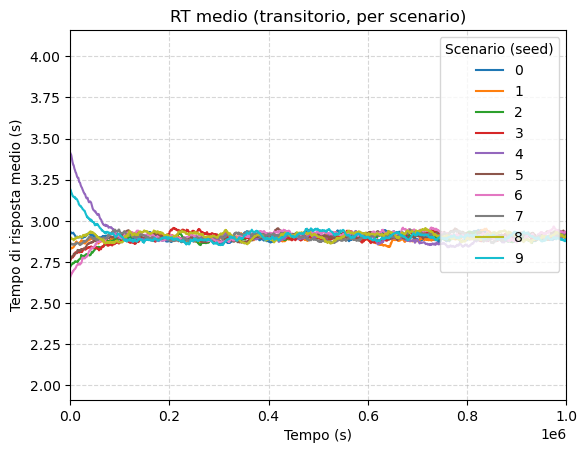

In [ ]:
fig, ax, stats = plot_rt_mean_per_scenario(
    dfs_jobs, x_col="Completion", y_col="TempoRispostaTotal",
    bin_size=800, x_max=1000000, ema_alpha=0.02,y_pad_frac=1
  
)

#fare throughtup per server
#fare tempi di risposta per ogni server 
#Utilizzazione

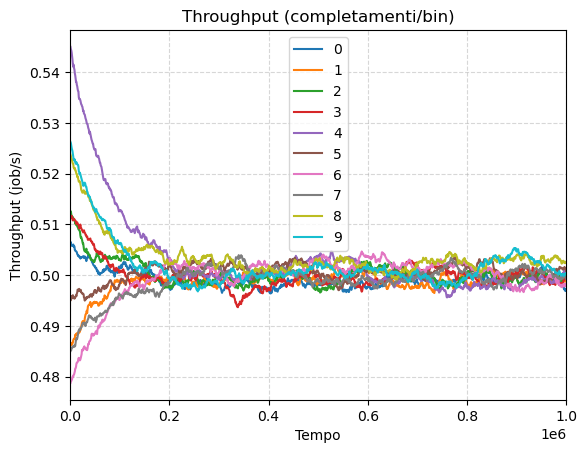

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Mapping, Iterable, Any

def plot_throughput_per_scenario(
    dfs_runs: Mapping[Any, pd.DataFrame] | Iterable[pd.DataFrame],
    *,
    x_col: str = "Completion",      # tempo degli OUT (completamenti)
    bin_size: float = 100.0,        # ampiezza intervallo (stesse unità di x_col)
    x_max: float | None = None,     # orizzonte massimo
    ema_alpha: float | None = None, # smoothing opzionale (EMA) solo per visual
    per_unit: str = "per_second",   # "per_second", "per_minute", "per_hour"
    title: str = "Throughput per scenario",
    xlabel: str = "Tempo",
    ylabel: str | None = None,
    legend: bool = True,
    grid: bool = True,
    show: bool = True
):
    """
    Conta i job completati in ciascun bin temporale e divide per bin_size.
    Ritorna (fig, ax, stats_per_run) con, per ogni run: t (centro bin), count, thr.
    """
    # normalizza input
    if isinstance(dfs_runs, Mapping):
        items = list(dfs_runs.items())
    else:
        items = [(f"scenario-{i+1}", df) for i, df in enumerate(dfs_runs)]
    if not items:
        raise ValueError("dfs_runs è vuoto.")

    # trova x_max se non dato
    if x_max is None:
        x_vals = []
        for _, df in items:
            if x_col in df.columns:
                x_vals.append(pd.to_numeric(df[x_col], errors="coerce").max())
        x_vals = pd.Series(x_vals).dropna()
        if x_vals.empty:
            raise ValueError(f"Colonna {x_col!r} non trovata/valida.")
        x_max = float(x_vals.max())

    # bordi bin
    n_bins = int(np.ceil(x_max / bin_size))
    edges = np.linspace(0.0, n_bins * bin_size, n_bins + 1)
    centers = (edges[:-1] + edges[1:]) / 2.0

    # fattore unità (solo etichetta; i valori restano count/bin_size in secondi)
    unit_factor = 1.0
    unit_label = "job/s"
    if per_unit == "per_minute":
        unit_factor = 60.0
        unit_label = "job/min"
    elif per_unit == "per_hour":
        unit_factor = 3600.0
        unit_label = "job/h"

    if ylabel is None:
        ylabel = f"Throughput ({unit_label})"

    fig, ax = plt.subplots()
    stats_per_run: dict[str, pd.DataFrame] = {}

    for label, df in items:
        if not (isinstance(df, pd.DataFrame) and x_col in df.columns):
            continue

        x = pd.to_numeric(df[x_col], errors="coerce").dropna()
        x = x[(x >= 0) & (x <= x_max)]
        if x.empty:
            continue

        # conteggio per bin
        counts, _ = np.histogram(x.to_numpy(), bins=edges)
        thr = (counts / bin_size) * unit_factor  # job per unità di tempo scelta

        # smoothing opzionale
        if ema_alpha is not None and 0 < ema_alpha < 1:
            thr = pd.Series(thr).ewm(alpha=ema_alpha, adjust=False).mean().to_numpy()

        ax.plot(centers, thr, label=str(label))

        stats_per_run[str(label)] = pd.DataFrame({
            "t": centers,
            "count": counts,
            "throughput": thr
        })

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, x_max)
    if grid:
        ax.grid(True, linestyle="--", alpha=0.5)
    if legend:
        ax.legend()

    if show:
        plt.show()

    return fig, ax, stats_per_run


fig, ax, thr_stats = plot_throughput_per_scenario(
    dfs_jobs,
    x_col="Completion",
    bin_size=800,          # stesso ordine che stavi usando
    x_max=1000000,
    ema_alpha=0.01,        # leggero smoothing per visual
    per_unit="per_second", # oppure "per_minute"/"per_hour"
    title="Throughput (completamenti/bin)"
)


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Mapping, Iterable, Any, Sequence

def plot_utilization_per_scenario(
    dfs_runs: Mapping[Any, pd.DataFrame] | Iterable[pd.DataFrame],
    *,
    servers: Sequence[str] = ("A","B","P"),   # quali server tracciare
    bin_size: float = 100.0,                  # ampiezza bin (stesse unità di tempo del df)
    x_max: float | None = None,               # orizzonte max
    ema_alpha: float | None = None,           # smoothing opzionale (EMA) solo visual
    title: str = "Utilizzazione per scenario (per server)",
    xlabel: str = "Tempo",
    ylabel: str = "Utilizzazione (frax)",
    legend: bool = True,
    grid: bool = True,
    show: bool = True,
):
    """
    Per ogni scenario e per ogni server in `servers`, calcola l'utilizzazione per bin temporali.
    L'utilizzazione di un bin è (tempo_in_busy / bin_size), ∈ [0,1].
    Ritorna (fig, ax, stats) dove:
      stats[(label, server)] = DataFrame { t, busy_time, utilization }
    """
    # normalizza input
    if isinstance(dfs_runs, Mapping):
        items = list(dfs_runs.items())
    else:
        items = [(f"scenario-{i+1}", df) for i, df in enumerate(dfs_runs)]
    if not items:
        raise ValueError("dfs_runs è vuoto.")

    # scopri K (quante visite max) dal primo df
    df0 = next(df for _, df in items if isinstance(df, pd.DataFrame))
    K = max(
        int(c.split("_")[1]) for c in df0.columns if c.startswith("Server_")
    ) if any(c.startswith("Server_") for c in df0.columns) else 5

    # trova x_max se non dato (usa Completion se presente altrimenti OUT_k max)
    if x_max is None:
        xmaxs = []
        for _, df in items:
            if "Completion" in df.columns:
                xmaxs.append(pd.to_numeric(df["Completion"], errors="coerce").max())
            else:
                for i in range(1, K+1):
                    col = f"OUT_{i}"
                    if col in df.columns:
                        xmaxs.append(pd.to_numeric(df[col], errors="coerce").max())
        x_max = float(pd.Series(xmaxs).dropna().max())

    # binning
    n_bins = int(np.ceil(x_max / bin_size))
    edges = np.linspace(0.0, n_bins * bin_size, n_bins + 1)
    centers = (edges[:-1] + edges[1:]) / 2.0

    def add_interval_to_bins(start: float, end: float, accum: np.ndarray):
        """Somma la lunghezza dell'intersezione [start,end) a ciascun bin."""
        if end <= start: 
            return
        # clamp a [0, x_max]
        s = max(0.0, min(start, x_max))
        e = max(0.0, min(end,   x_max))
        if e <= s:
            return
        # indice del primo/ultimo bin toccato
        i = int(np.floor(s / bin_size))
        j = int(np.floor((e - 1e-12) / bin_size))
        for b in range(i, j + 1):
            bin_s = edges[b]
            bin_e = edges[b+1]
            overlap = max(0.0, min(e, bin_e) - max(s, bin_s))
            if overlap > 0:
                accum[b] += overlap

    fig, ax = plt.subplots()
    stats: dict[tuple[str,str], pd.DataFrame] = {}

    for label, df in items:
        if not isinstance(df, pd.DataFrame):
            continue

        # Prepara per ciascun server la lista intervalli [IN_k, OUT_k) in cui Server_k==server
        for server in servers:
            busy_per_bin = np.zeros(n_bins, dtype=float)

            for i in range(1, K+1):
                serv_col = f"Server_{i}"
                in_col   = f"IN_{i}"
                out_col  = f"OUT_{i}"
                if serv_col not in df.columns or in_col not in df.columns or out_col not in df.columns:
                    continue

                mask = (df[serv_col] == server)
                if not mask.any():
                    continue

                ins  = pd.to_numeric(df.loc[mask, in_col],  errors="coerce").to_numpy()
                outs = pd.to_numeric(df.loc[mask, out_col], errors="coerce").to_numpy()

                # accumula unione temporale via sweep (ottimizza evitando doppio conteggio)
                # Costruisci eventi (+1 a IN, -1 a OUT)
                events = []
                for a, b in zip(ins, outs):
                    if pd.isna(a) or pd.isna(b):
                        continue
                    if b <= 0 or a >= x_max:
                        continue
                    events.append((max(a, 0.0), +1))
                    events.append((min(b, x_max), -1))
                if not events:
                    continue

                events.sort()
                level = 0
                last_t = None
                for t_ev, delta in events:
                    if last_t is not None and level > 0:
                        # intervallo [last_t, t_ev) è busy
                        add_interval_to_bins(last_t, t_ev, busy_per_bin)
                    level += delta
                    last_t = t_ev

            util = busy_per_bin / bin_size
            util = np.clip(util, 0.0, 1.0)

            # smoothing visual opzionale
            if ema_alpha is not None and 0 < ema_alpha < 1:
                util = pd.Series(util).ewm(alpha=ema_alpha, adjust=False).mean().to_numpy()

            ax.plot(centers, util, label=f"{label} — {server}")

            stats[(str(label), server)] = pd.DataFrame({
                "t": centers,
                "busy_time": busy_per_bin,
                "utilization": util
            })

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, x_max)
    ax.set_ylim(0, 1.0)
    if grid:
        ax.grid(True, linestyle="--", alpha=0.5)
    if legend:
        ax.legend(ncol=2)

    if show:
        plt.show()

    return fig, ax, stats





IndexError: index 1251 is out of bounds for axis 0 with size 1251

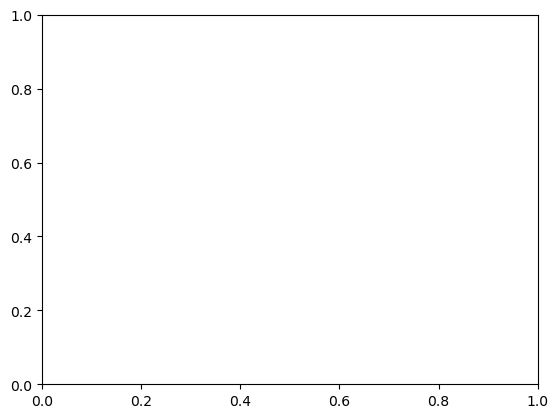

In [40]:
fig, ax, util_stats = plot_utilization_per_scenario(
    dfs_jobs,
    servers=("A","B","P"),
    bin_size=800,
    x_max=1000000,
    ema_alpha=0.02,   # solo estetica
    title="Utilizzazione per scenario e server"
)
